In [1]:
!pip install transformers
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 53.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


## Importing necessary library

In [2]:
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
from transformers import DataCollatorWithPadding

from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np

from tqdm.auto import tqdm

### Initializations

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
MAX_LEN = 256
BATCH_SIZE = 32

#### loading the data

In [5]:
from google.colab import files
uploaded = files.upload()

Saving IMDB Dataset.xls to IMDB Dataset.xls


#### loading the data

In [6]:
imdb = pd.read_csv("IMDB Dataset.xls")

In [7]:
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Data preprocessing

Before the augmentation is carried out, there would be data preprocessing i.e., cleaning the data to make it more suitable for input in our machine learning model. Some common steps for preprocessing includes lowercase conversion, punctuation removal, stopwords removal and white space removal.

In [8]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("punkt")
import re
from tqdm.auto import tqdm
import string

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
imdb["sentiment"].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [10]:
# convert to lower
def convert_to_lower(text):
    return text.lower()

In [11]:
# remove_punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("", "", string.punctuation))

In [12]:
# remove stopwords
def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

In [13]:
# remove extra white spaces
def remove_extra_white_spaces(text):
    single_char_pattern = r"\s+[a-zA-Z]\s+"
    without_sc = re.sub(pattern = single_char_pattern, repl=" ", string=text)
    return without_sc

#### Applying the above to the IMDB dataset

In [14]:
imdb["review"] = imdb["review"].apply(lambda x: convert_to_lower(x))
imdb["review"] = imdb["review"].apply(lambda x: remove_punctuation(x))
imdb["review"] = imdb["review"].apply(lambda x: remove_stopwords(x))
imdb["review"] = imdb["review"].apply(lambda x: remove_extra_white_spaces(x))

In [15]:
class_names = ["positive", "negative"]

#### convert the sentiment to a numerical column

In [16]:
label_encoder = LabelEncoder()

In [17]:
imdb["sentiment_encoded"] = label_encoder.fit_transform(imdb["sentiment"])

In [18]:
# checking new dataframe
imdb.head(2)

,review,sentiment,sentiment_encoded
0,one reviewers mentioned watching 1 oz episode ...,positive,1
1,wonderful little production br br filming tech...,positive,1


#### splitting the dataset

In [19]:
df_train, df_test = train_test_split(imdb, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)

In [20]:
print(df_train.shape, df_test.shape)

(35000, 3) (15000, 3)


### Creating a custom dataset class

In [21]:
class IMDBDataset(Dataset):
    def __init__(self, df, reviews, targets, tokenizer, max_len, include_raw_text=False):
        self.df = df
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.include_raw_text = include_raw_text

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        reviews = (self.reviews[idx])
        target = self.targets[idx]

        encoding = self.tokenizer.encode_plus(
            reviews,
            max_length = self.max_len,
            truncation = True,
            add_special_tokens = True,
            return_token_type_ids = True,
            padding = True,
            return_attention_mask = True,
            return_tensors = "pt"
        )

        output = {
            "input_ids" : encoding["input_ids"].flatten(),
            "attention_mask" : encoding["attention_mask"].flatten(),
            "token_type_ids" : encoding["token_type_ids"].flatten(),
            "targets" : torch.tensor(target, dtype = torch.long)
        }

        if self.include_raw_text:
            output["review_text"] = reviews

        return output

In [22]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
collator = DataCollatorWithPadding(tokenizer = tokenizer, padding="longest")

### creating a dataloader with the above dataset class

In [23]:
def Create_data_loader(imdb, tokenizer, max_len = MAX_LEN, batch_size = BATCH_SIZE, include_raw_text = False):
    dataset = IMDBDataset(
        df = imdb,
        reviews = imdb["review"].to_list(),
        targets = imdb["sentiment_encoded"].to_list(),
        tokenizer= tokenizer,
        max_len = max_len,
        include_raw_text=include_raw_text
    )
    return DataLoader(dataset, batch_size=batch_size, collate_fn=collator)

#### dataloader definition

In [24]:
train_dataloader = Create_data_loader(df_train, tokenizer=tokenizer)
test_dataloader = Create_data_loader(df_test, tokenizer=tokenizer)

## Building a head classifier to add to the body of the pretrained model

In [25]:
class BERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased", return_dict = False, from_tf = False) #body
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask,
        token_type_ids = token_type_ids
        )

        output = self.drop(pooled_output)
        output = self.out(output)
        return output

In [26]:
model = BERTClassifier(num_classes=len(class_names))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
model.to(device)

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

### loss function and optimizer

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-05)
NUM_EPOCHS = 5
total_steps = len(train_dataloader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

### training loop

In [29]:
train_losses = []

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")

    #if epoch%2 == 0:
        #checkpoint = {
            #"state_dict" : model.state_dict(),
            #"optimizer" : optimizer.state_dict(),
            #"epoch" : epoch
        #}
        #torch.save(checkpoint, "C:/Users/Hp/Documents/ML/my_checkpoint.pth")

    for idx, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        input_ids = batch["input_ids"].to(device, dtype = torch.long)
        attention_mask = batch["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = batch["token_type_ids"].to(device, dtype = torch.long)
        targets = batch["targets"].to(device, dtype = torch.long)

        # forward pass
        outputs = model(input_ids, attention_mask, token_type_ids)
        loss = criterion(outputs, targets)

        running_loss += loss.item()
        train_losses.append(running_loss)

        #back propagation
        optimizer.zero_grad()
        loss.backward()

        # gradient descent
        optimizer.step()
        scheduler.step()
    epoch_loss = running_loss / len(train_dataloader)
    print("Epoch {} loss: {:.3f}".format(epoch + 1, epoch_loss))

Epoch [1/5]


  0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 1 loss: 0.294
Epoch [2/5]


  0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 2 loss: 0.147
Epoch [3/5]


  0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 3 loss: 0.061
Epoch [4/5]


  0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 4 loss: 0.024
Epoch [5/5]


  0%|          | 0/1094 [00:00<?, ?it/s]

Epoch 5 loss: 0.013


### test loop

In [30]:
test_loss = 0.0
correct_pred = 0.0
total_samples = 0.0
test_losses = []
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, total = len(test_dataloader)):
        input_ids = batch["input_ids"].to(device, dtype = torch.long)
        attention_mask = batch["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = batch["token_type_ids"].to(device, dtype = torch.long)
        targets = batch["targets"].to(device, dtype = torch.long)

        # forward pass
        outputs = model(input_ids, attention_mask, token_type_ids)
        loss = criterion(outputs, targets)

        # get loss
        test_loss = loss.item()
        test_losses.append(test_loss)

        # get prediction
        _, predicted = torch.max(outputs, dim=1)
        total_samples += targets.size(0)

        # calculate accuracy
        correct_pred += (predicted == targets).sum()

        # get predicted and actual labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

test_loss /= len(test_dataloader.dataset)
accuracy = correct_pred / total_samples

# view loss and accuracy
print("Test Loss: {:.3f} | Accuracy: {:.3f}".format(test_loss, accuracy))

  0%|          | 0/469 [00:00<?, ?it/s]

Test Loss: 0.000 | Accuracy: 0.909


### Visualization

In [31]:
import matplotlib.pyplot as plt

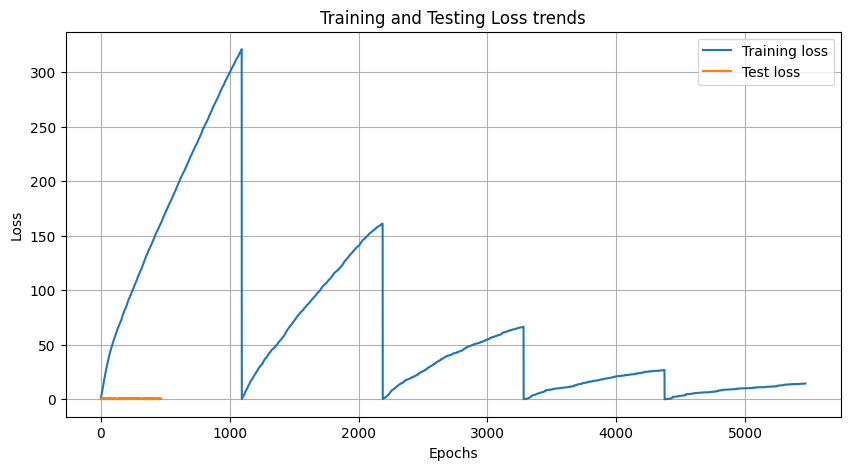

In [37]:
# plotting the epoch-to-train and test trend
plt.figure(figsize = (10, 5))
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss trends")
plt.legend()
plt.grid(True)
plt.show()

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [39]:
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average = "weighted")
recall = recall_score(all_labels, all_predictions, average = "weighted")
f1 = f1_score(all_labels, all_predictions, average = "weighted")

In [40]:
print(f"Accuracy: {accuracy:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, F1: {f1:.3f}")

Accuracy: 0.909, precision: 0.909, recall: 0.909, F1: 0.909
